# 単振動に対するKalman Filter(カルマンフィルタ)

## 単振動の数値計算
単振動: $\omega > 0 $
$$\frac{d^2 x}{dt^2} = - \omega^2 x.$$

1階の方程式に書き換え:
$$ \frac{dx}{dt} = v,$$
$$ \frac{dv}{dt} = -\omega^2 x.$$


例えば，Heun法で解くと，$\Delta t > 0 $に対し以下のように離散化される．
$$
\left(
    \begin{array}{c}
        x_{k+1} \\
        v_{k+1}
    \end{array}
\right)
= 
\left(
    \begin{array}{cc}
        (1 - \frac{1}{2} \omega^2 (\Delta t)^2) x_k + \Delta t v_k \\
        - \omega^2 \Delta t x_k + (1 - \frac{1}{2} \omega^2 (\Delta t)^2) v_k
    \end{array}
\right).
$$

In [296]:
# データ保存先
data_dir = "../data"

"../data"

In [297]:
omega = pi # パラメータ

dt = 0.1 # 時間刻み幅

# 初期値
x0 = 2.0
v0 = 0.0

N = 200 # 反復回数


# Heun法で単振動をdt時間発展する
function evolve_heun(x_old, v_old)
    x = x_old
    v = v_old
    x = (1 - 0.5 * omega^2 * dt^2) * x_old + dt * v_old
    v = - omega^2 * dt * x_old + (1 - 0.5 * omega^2 * dt^2) * v_old

    return x, v
end

# Euler法で単振動をdt時間発展する
function evolve_euler(x_old, v_old)
    x = x_old
    v = v_old
    x = x_old + dt * v_old
    v = - omega^2 * dt * x_old + v_old

    return x, v
end


# Symplectic Euler法で単振動をdt時間発展する
function evolve_sympeuler(x_old, v_old)
    x = x_old
    v = v_old
    v = - omega^2 * dt * x_old + v_old
    x = x_old + dt * v

    return x, v
end


# Leapfrog法で単振動をdt時間発展する
function evolve_leapfrog(x_old, v_old)
    # ハーフステップで速度を更新しシンプレクティック性を保つ
    v_half = v_old - 0.5 * omega^2 * dt * x_old
    # ずらした速度を用いて位置を進める
    x_new = x_old + dt * v_half
    # 新しい位置を使って速度更新を完了する
    v_new = v_half - 0.5 * omega^2 * dt * x_new

    return x_new, v_new
end


# メインループ
x_array = [x0]
v_array = [v0]
x = x0
v = v0
for n in 1:N
    # 使用する積分法を切り替えて比較できるようにする
    # x, v = evolve_heun(x, v) # Heun法
    # x, v = evolve_euler(x, v) # Euler法
    # x, v = evolve_sympeuler(x, v) # Symplectic Euler法
    x, v = evolve_leapfrog(x, v) # Leapfrog法
    push!(x_array, x) # 配列に追加
    push!(v_array, v) # 配列に追加
end


# プロット

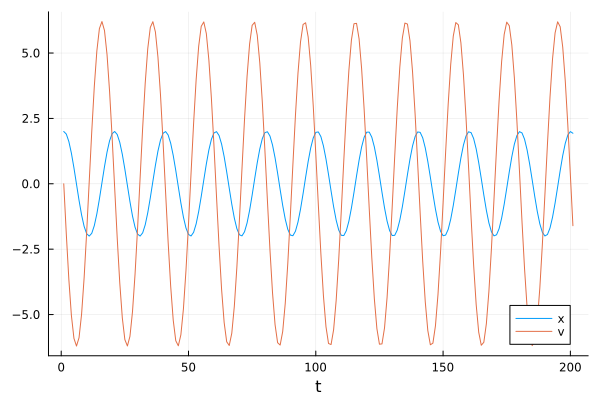

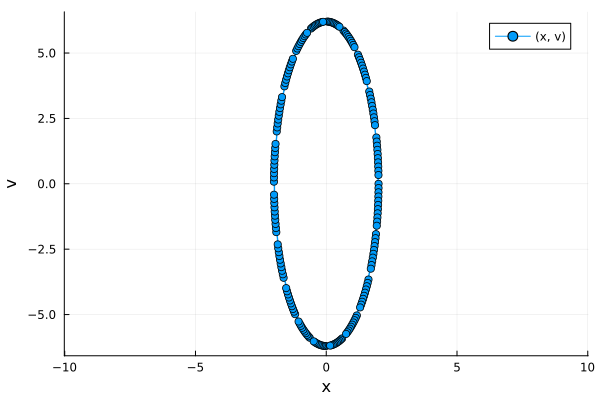

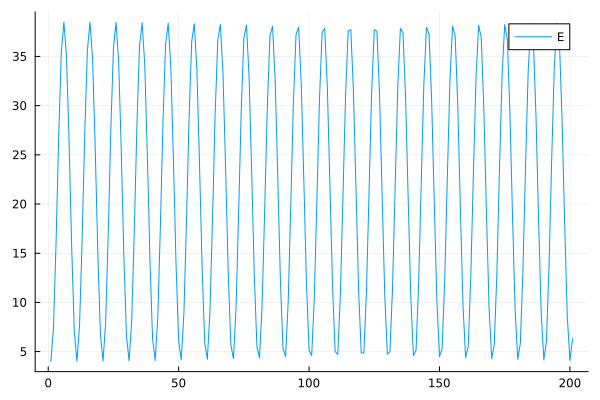

In [298]:
using Plots
gr() # GRバックエンドを使用

# x(t), v(t)をプロット
p1 = plot([x_array v_array], label=["x" "v"], xlabel="t")

# (x, v)平面で軌道をプロット
p2 = plot(x_array, v_array, aspect_ratio=1, marker = :circle, label="(x, v)", xlabel="x", ylabel="v")

# エネルギーの時系列をプロット
E_array = [x_array[n]^2 + v_array[n]^2 for n in 1:N+1]
p3 = plot(E_array, label="E")

# Notebook上で表示
display(p1)
display(p2)
display(p3)


## 状態からの観測
簡単のため，観測間隔が一定で $\tau>0$ であるとする．
時刻 $t_n = n \tau$ における状態ベクトル $\boldsymbol{x}_n = (x_n, v_n)^\top$に対して，観測値 $y_n$ が
$$y_n = H \boldsymbol{x}_n = x_n + \eta$$
と得られるとする．ただし，$H = [1 \ 0]$であり，$\eta$ は標準偏差 $r>0$ に対して，正規分布 $\mathcal{N}(0, r^2)$ に従うとする．

In [299]:
# 観測時間間隔
obs_per = 2
tau = obs_per * dt # 上で書いた観測時間間隔

println("obs_per: ", obs_per)
# obs_perは観測間のモデルステップ数を表す
println("tau: ", tau)

# 観測のモデル化
H = [1.0 0.0] # 観測行列
r = 1.0
R = [r^2]    # 観測ノイズの共分散行列(ここでは分散のみ)

# 真の状態には解析解を使う
function x_analytical(t)
    return x0 * cos(omega * t) + v0 / omega * sin(omega * t)
end

function v_analytical(t)
    return -x0 * omega * sin(omega * t) + v0 * cos(omega * t)
end

# 解析解を評価する時間格子．時間刻み幅ごとに取っている．
t_esti_array = [dt * n for n in 0:N]
# println(t_esti_array)

# フィルタ精度を評価するための解析解
x_true = [x_analytical(t) for t in t_esti_array]
v_true = [v_analytical(t) for t in t_esti_array]
x_true = hcat(x_true, v_true) # 真の状態ベクトルの配列 (N+1, 2)
println("x_true.size: ", x_true.size)

obs_per: 2
tau: 0.2
x_true.size: (201, 2)


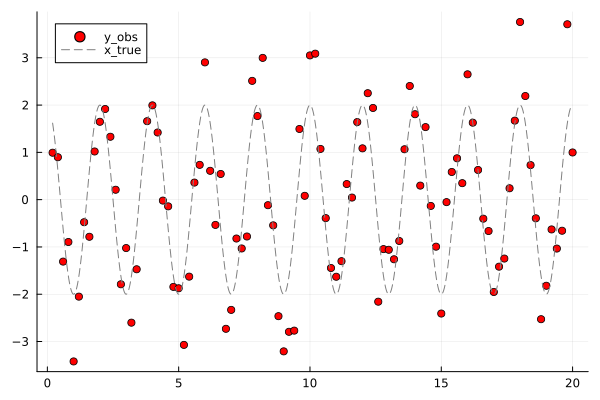

In [300]:
# 観測データの生成
using Random
Random.seed!(77) # 再現性確保のため乱数を固定
y_array = []
t_obs_array = []
# 設定した間隔ごとに雑音付き観測を生成
for n in 1:N
    if n%obs_per==0
        y = H * x_true[n+1, :] .+ sqrt(R[1]) * randn() # 観測値の生成 R.size == (1, )を仮定．x_true[1]は初期値なので観測しない
        push!(y_array, y)
        push!(t_obs_array, n*dt)
    end
end

using Plots
using Statistics
gr() # GRバックエンドを使用

# 可視化のための処理
y_values = [y[1] for y in y_array]

# プロット
p1 = scatter(t_obs_array, y_values, label="y_obs", color=:red)
plot!(p1, t -> x_analytical(t), label="x_true", color=:gray, linestyle=:dash)

display(p1)


## カルマンフィルタ（Kalman filter: KF）
カルマンフィルタの適用には時間発展の遷移行列表示が必要．
ただし，以下のように書き換えるだけ．
$$
\left(
    \begin{array}{c}
        x_{k+1} \\
        v_{k+1}
    \end{array}
\right)
=
\left(
    \begin{array}{cc}
        (1 - \frac{1}{2} \omega^2 (\Delta t)^2) x_k + \Delta t v_k \\
        - \omega^2 \Delta t x_k + (1 - \frac{1}{2} \omega^2 (\Delta t)^2) v_k
    \end{array}
\right)
= 
\left(
    \begin{array}{cc}
        1 - \frac{1}{2} \omega^2 (\Delta t)^2 & \Delta t \\
        - \omega^2 \Delta t & 1 - \frac{1}{2} \omega^2 (\Delta t)^2
    \end{array}
\right)
\left(
    \begin{array}{c}
        x_k \\
        v_k
    \end{array}
\right).
$$
（これはHeun法の場合）

In [ ]:
# まず，KalmanFilterのアルゴリズムを実装しておく

module KalmanFilter
    using LinearAlgebra

    export KalmanFilter, forecast, analysis

    # 状態・共分散・モデル行列を保持する最小構成のカルマンフィルタ
    mutable struct KalmanFilter
        """
        x_n = _F x_{n-1} + xi_n, xi_n ~ N(0, _Q)
        y_n = _H x_n + eta_n, eta_n ~ N(0, _R)
        x_esti_n ~ N(_m, _P) 
        """
        _m # 平均
        _P # 共分散
        _F # 状態遷移行列(時間依存しないと仮定)
        _H # 観測行列(時間依存しないと仮定)
        _Q # モデル誤差共分散(時間依存しないと仮定)
        _R # 観測誤差共分散(時間依存しないと仮定)
        _I # 計算に必要な単位行列(_Pと同じサイズ)

        function KalmanFilter(m0, P0, F, H, Q, R)
            return new(m0, P0, F, H, Q, R, 1.0I(size(P0, 1)))
        end
    end

    # 1ステップ先へ予測を進める
    function forecast(kf::KalmanFilter)
        kf._m = kf._F * kf._m
        kf._P = kf._F * kf._P * kf._F' + kf._Q
    end

    # 観測値yをカルマンゲインで取り込み更新する
    function analysis(kf::KalmanFilter, y)
        K = kf._P * kf._H' * inv(kf._H * kf._P * kf._H' + kf._R)
        kf._m = kf._m + K * (y - kf._H * kf._m)
        kf._P = (kf._I - K * kf._H) * kf._P
    end
end


Main.KalmanFilter

In [302]:
# NOTE: omegaは既知とする
# 時間発展dtに対応する状態遷移行列
# (上で定義した時間発展の数値計算コードを状態遷移行列で書き直す必要がある．)
F_euler = [1 dt;
           - omega^2 * dt 1]
F_heun = [1 - 0.5 * omega^2 * dt^2  dt;
          - omega^2 * dt         1 - 0.5 * omega^2 * dt^2]

F_sympeuler = [1 - omega^2 * dt^2  dt;
               - omega^2 * dt      1] 

F_leapfrog = [1 - 0.5 * omega^2 * dt^2                             dt;
              - omega^2 * dt * (1 - 0.25 * omega^2 * dt^2)  1 - 0.5 * omega^2 * dt^2]

q1 = 0.001
q2 = 0.1
Q = [q1 0.0;
     0.0 q2] # 時間発展モデルノイズの共分散行列

m0_kf = [0.0; 0.0] # 初期状態の推定値
P0_kf = [4.0 0.0;
         0.0 4.0] # 初期誤差共分散

using .KalmanFilter
# 遷移行列を選択してカルマンフィルタを初期化
# F = F_euler
F = F_heun
# F = F_sympeuler
# F = F_leapfrog
kf = KalmanFilter.KalmanFilter(m0_kf, P0_kf, F, H, Q, R)

xa_array = [] # 観測更新後の推定値を保存
Pa_array = [] # 観測更新後の誤差共分散を保存

# 初期推定を保存
push!(xa_array, copy(m0_kf))
push!(Pa_array, copy(P0_kf))

# モデルを時間発展させ観測が得られたタイミングで更新
for n in 1:N
    KalmanFilter.forecast(kf)
    if n%obs_per==0
        y = y_array[Int(n/obs_per)]
        KalmanFilter.analysis(kf, y)
    end
    push!(xa_array, copy(kf._m))
    push!(Pa_array, copy(kf._P))
end

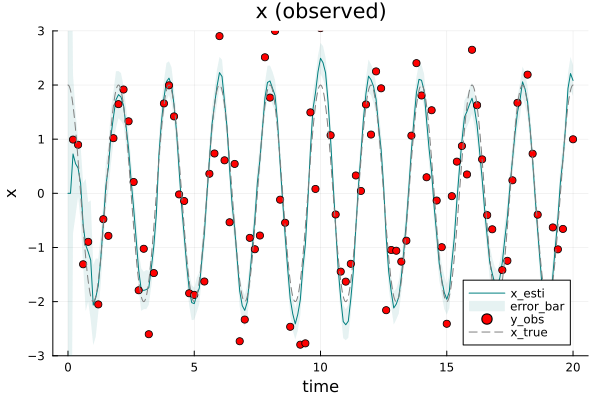

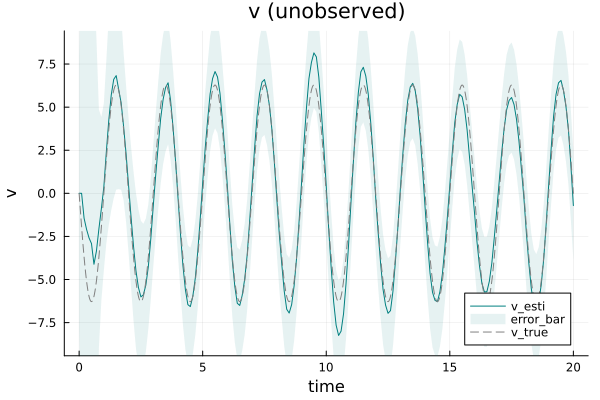

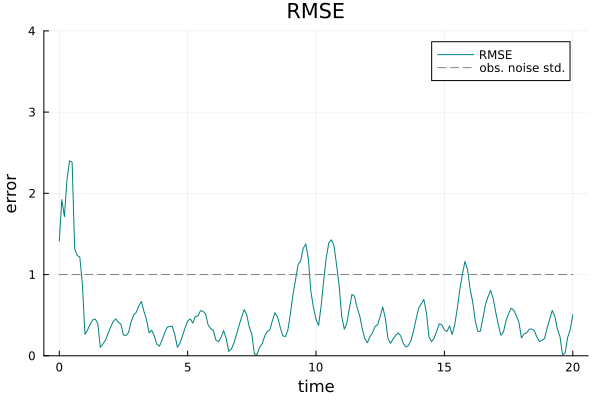

RMSE time average = 0.49570672917376474


"/Users/kotatakeda/Documents/GitHub/da_math_intro/data/rmse.pdf"

In [303]:
using Plots
using Statistics
gr() # GRバックエンドを使用

# 可視化のための処理
xa_matrix = reduce(hcat, xa_array)' # 推定値を列結合して時間方向に並べる
y_values = [y[1] for y in y_array] # 観測値をプロットのために整形
sigma_x = [Pa[1, 1] for Pa in Pa_array] # HPaH^Tの時系列．ここでは観測されているx変数に対する推定の不確実性(標準偏差)を表す
x_upper = xa_matrix[:, 1] + 2*sigma_x # 標準偏差2倍分のエラーバー(上限)
x_lower = xa_matrix[:, 1] - 2*sigma_x # 標準偏差2倍分のエラーバー(下限)
sigma_v = [Pa[2, 2] for Pa in Pa_array] # (I-H)Pa(I-H)^Tの時系列．ここでは未観測のv変数に対する推定の不確実性(標準偏差)を表す
v_upper = xa_matrix[:, 2] + 2*sigma_v # 標準偏差2倍分のエラーバー(上限)
v_lower = xa_matrix[:, 2] - 2*sigma_v # 標準偏差2倍分のエラーバー(下限)


# プロット
p1 = plot(t_esti_array, xa_matrix[:, 1], label="x_esti", xlabel="time", ylabel="x", ylims=(-3, 3), color=:teal) # 推定値をプロット
plot!(p1, t_esti_array, x_upper, linewidth=0, alpha=0, color=:teal, label="") # エラーバーの上限のためのプロット
plot!(p1, t_esti_array, x_lower, fillrange = x_upper, fillalpha=0.1, linewidth=0, alpha=0, color=:teal, label="error_bar")
scatter!(p1, t_obs_array, y_values, label="y_obs", color=:red)
plot!(p1, t -> x_analytical(t), label="x_true", color=:gray, linestyle=:dash) # 真の時系列(解析解)
title!(p1, "x (observed)")
display(p1)

p2 = plot(t_esti_array, xa_matrix[:, 2], label="v_esti", xlabel="time", ylabel="v", ylims=(-omega*3, omega*3), color=:teal)
plot!(p2, t_esti_array, v_upper, linewidth=0, alpha=0, color=:teal, label="") # エラーバーの上限のためのプロット
plot!(p2, t_esti_array, v_lower, fillrange = v_upper, fillalpha=0.1, linewidth=0, alpha=0, color=:teal, label="error_bar")
plot!(p2, t -> v_analytical(t), label="v_true", color=:gray, linestyle=:dash)
title!(p2, "v (unobserved)")
display(p2)

# 評価のため推定時刻における真の軌道を計算
x_true_est = [x_analytical(t) for t in t_esti_array]
v_true_est = [v_analytical(t) for t in t_esti_array]
x_true_matrix = hcat(x_true_est, v_true_est)

# 状態2成分におけるフィルタと真値のずれをRMSEで示す
rmse_series = [sqrt(mean((xa_matrix[i, :] .- x_true_matrix[i, :]).^2)) for i in 1:length(t_esti_array)]
p3 = plot(t_esti_array, rmse_series, label="RMSE", xlabel="time", ylabel="error", ylims=(0, 4), color=:teal)
plot!(p3, t -> sqrt(R[1]), label="obs. noise std.", xlabel="time", color=:gray, linestyle=:dash)
title!(p3, "RMSE")
display(p3)

rmse_mean = mean(rmse_series)
println("RMSE time average = $(rmse_mean)")

# 保存
savefig(p1, "$data_dir/x_esti.pdf")
savefig(p2, "$data_dir/v_esti.pdf")
savefig(p3, "$data_dir/rmse.pdf")
